# Union Membership, Mobilization, & Turnout

## Jake Caldwell
### Multilevel Models
### 4/29/2023
***
***

# ANES Data Import

**ANES Time Series Cumulative Data File (1948-2020)**

__[Codebook](https://electionstudies.org/anes_timeseries_cdf_codebook_var_20220916/)___

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt   
import seaborn as sns   

In [147]:
anes = pd.read_csv('anes_ts.csv',usecols=['VCF0004', # Year of study
                                          'VCF9030a', 'VCF9030b','VCF9030c', # Contact (both,dnc,rep)
                                          'VCF0127', # Union Household
                                          'VCF0104', # Gender
                                          'VCF0105b',# Race (4 category)
                                          'VCF0114', # Income percentile
                                          'VCF0140a', # Education (7 category)
                                          'VCF0101', # Age
                                         'VCF0130', # Church Attendance
                                          'VCF0112',  # Region
                                          'VCF0303', # Party ID (3 category)
                                          'VCF0301', # Partisan ID (7-category)
                                          'VCF0901a']) # State
data = pd.DataFrame(anes)

In [148]:
data2 = (data.replace(r'^\s*$', np.nan, regex=True)) # Remove spaces, replace w/ NaN

In [149]:
data3 = data2.rename(columns= 
                     {'VCF0004':'year', 
                      'VCF0101':'age', 
                      'VCF0104':'gender',
                      'VCF0105b':'race',
                      'VCF0112':'region',
                      'VCF0114':'income',
                      'VCF0127':'union',
                      'VCF0140a':'educ',
                      'VCF0303':'party',
                      'VCF0301':'partisanship',
                      'VCF0130': 'church',
                      'VCF0703':'regvote',
                      'VCF0901a' :'state',
                      'VCF9030a':'contact_gen',
                      'VCF9030b':'contact_dnc',
                      'VCF9030c':'contact_gop',})

In [150]:
df = data3.copy()
df = df.astype('float64')

# ANES Data Transformation
***
###  Limit to Presidential Elections, 1964-2020

In [151]:
df = df.loc[df['year'].isin([1972,1976,1980,1984,1988,1992,1996,
                               2000,2004,2008,2012,2016,2020])].reset_index(drop=True)
# df.head(20)

#### Age

In [152]:
df['age'].replace(0,np.nan,inplace=True) # Transform 0 to NA

#### Gender

In [153]:
df['gender'].replace(0,np.nan,inplace=True) # Missing values
df['female'] = (df['gender']-1) # Create female variable
df['female'].replace(2,0,inplace=True) # Make 0/1

#### Race

In [154]:
df['race'].replace([0,9],np.nan,inplace=True) # Missing values
df['race'].replace([1,2,3,4],['white','black','hispanic','other'],inplace=True) # Strings
df = pd.concat([df, pd.get_dummies(df['race'])], axis=1) # Create individual race columns

#### Income

In [155]:
df['income'].replace(0,np.nan,inplace=True) # Missing values

#### Union Household

In [156]:
df['union'].replace(0,np.nan,inplace=True) # Missing values
df['union'].replace(2,0,inplace=True) # Make 0/1

#### Education

In [157]:
df['educ'].replace([8,9],np.nan,inplace=True) # 8 and 9 become NA

#### Party ID

In [158]:
df['party'].replace([0,1,2,3],[np.nan,'democrat','independent','republican'],inplace=True) # Convert to string

party_df = pd.get_dummies(df['party'],dummy_na=True) # Separate to work w/ NA column
party_df.columns = ['democrat','independent','republican','nan'] # Rename
party_df.loc[party_df.nan == 1, ['democrat','independent','republican']] = np.nan # Where NA=1, np.nan
party_df = party_df.drop(columns='nan') # Remove NA column

df = pd.concat([df, party_df], axis=1) # Return to dataset

#### Strength of Partisanship

In [159]:
df['part_strength'] = df['partisanship'].copy()
df['part_strength'] = df['part_strength'].replace([0,4,[3,5],[2,6],[1,7]],[np.nan,0,1,2,3])

#### Contact by Parties (Both, DNC, GOP)

In [160]:
df['contact_gen'].replace([[8,9],2],[np.nan,0],inplace=True) # Missing Values, Make 0/1
df['contact_dnc'].replace([[8,9],2],[np.nan,0],inplace=True)
df['contact_gop'].replace([[8,9],2],[np.nan,0],inplace=True)

#### Church Attendance (Binary)

In [161]:
df['church'].replace([[1,2,3,4],[5,7],[8,9,0]],[1,0,np.nan],inplace=True)

## Checking Data

In [162]:
df.loc[df['year']==1972.0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2705 entries, 0 to 2704
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           2705 non-null   float64
 1   age            2688 non-null   float64
 2   gender         2705 non-null   float64
 3   race           2705 non-null   object 
 4   region         2705 non-null   float64
 5   income         2612 non-null   float64
 6   union          2674 non-null   float64
 7   church         2677 non-null   float64
 8   educ           2702 non-null   float64
 9   partisanship   2705 non-null   float64
 10  party          2695 non-null   object 
 11  state          2705 non-null   float64
 12  contact_gen    1119 non-null   float64
 13  contact_dnc    1098 non-null   float64
 14  contact_gop    1098 non-null   float64
 15  female         2705 non-null   float64
 16  black          2705 non-null   uint8  
 17  hispanic       2705 non-null   uint8  
 18  other   

In [163]:
# df.tail(10)

In [164]:
df.loc[df['year']==1972.0]

,year,age,gender,race,region,income,union,church,educ,partisanship,...,contact_gop,female,black,hispanic,other,white,democrat,independent,republican,part_strength
0,1972.0,75.0,2.0,white,3.0,1.0,1.0,1.0,2.0,1.0,...,0.0,1.0,0,0,0,1,1.0,0.0,0.0,3.0
1,1972.0,49.0,2.0,white,3.0,3.0,0.0,1.0,2.0,4.0,...,0.0,1.0,0,0,0,1,0.0,1.0,0.0,0.0
2,1972.0,24.0,1.0,white,3.0,3.0,1.0,1.0,2.0,5.0,...,NaN,0.0,0,0,0,1,0.0,0.0,1.0,1.0
3,1972.0,21.0,1.0,white,2.0,3.0,0.0,1.0,3.0,6.0,...,1.0,0.0,0,0,0,1,0.0,0.0,1.0,2.0
4,1972.0,63.0,2.0,white,2.0,NaN,0.0,1.0,2.0,2.0,...,1.0,1.0,0,0,0,1,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,1972.0,26.0,2.0,white,1.0,4.0,1.0,1.0,2.0,4.0,...,NaN,1.0,0,0,0,1,0.0,1.0,0.0,0.0
2701,1972.0,65.0,2.0,white,1.0,4.0,0.0,0.0,3.0,1.0,...,NaN,1.0,0,0,0,1,1.0,0.0,0.0,3.0
2702,1972.0,36.0,2.0,white,1.0,3.0,0.0,1.0,3.0,7.0,...,NaN,1.0,0,0,0,1,0.0,0.0,1.0,3.0
2703,1972.0,73.0,2.0,white,1.0,1.0,0.0,1.0,1.0,1.0,...,NaN,1.0,0,0,0,1,1.0,0.0,0.0,3.0


# Aggregate Visualization
### General Contact (Union vs. General)

In [165]:
nondat= df.loc[df['union']==0]
uniondat= df.loc[df['union'] == 1]

In [166]:
gendat = nondat.groupby(df['year']).agg({'contact_gen' : np.mean}).rename(columns={'contact_gen':'non_gen'})

In [167]:
ungen = uniondat.groupby(df['year']).agg({'contact_gen' : np.mean}).rename(columns={'contact_gen':'union_gen'})

In [168]:
gendat = gendat.merge(ungen,on='year',how='left')
# gendat['diff'] = (gendat['union_gen'] - gendat['non_gen'])

#### Plotting

In [169]:
years = [1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020]

In [170]:
sns.set_style("darkgrid")

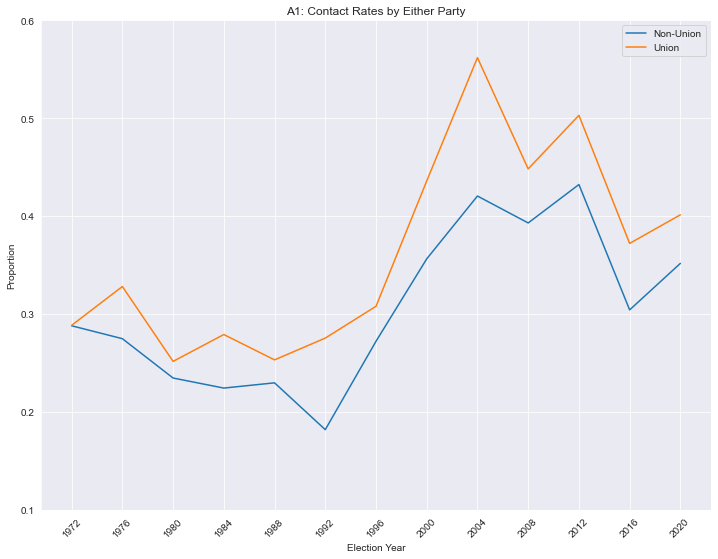

In [171]:
ax = gendat.plot(legend=False,xlabel='Election Year',
           ylabel='Proportion',
           figsize=[12,9],
           grid=True,
           rot=45,
           xticks=years,
           ylim=(0.1,.6))
plt.title("A1: Contact Rates by Either Party")
ax.legend(labels=("Non-Union",'Union'));

### Democratic Party Contact (Union vs. General)

In [172]:
demdat = nondat.groupby(df['year']).agg({'contact_dnc' : np.mean}).rename(columns={'contact_dnc':'non_dnc'})

In [173]:
undem = uniondat.groupby(df['year']).agg({'contact_dnc' : np.mean}).rename(columns={'contact_dnc':'union_dnc'})

In [174]:
demdat = demdat.merge(undem,on='year',how='left')

In [175]:
# demdat['diff'] = (demdat['union_dnc'] - demdat['non_dnc'])

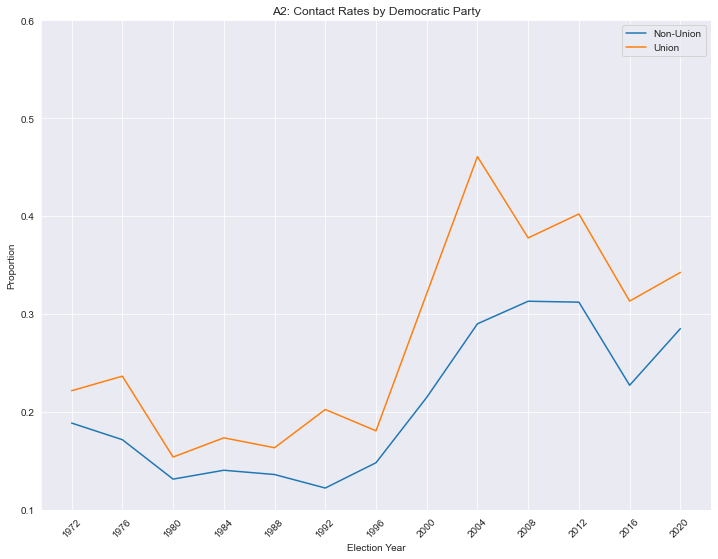

In [176]:
ax = demdat.plot(legend=False,xlabel='Election Year',
           ylabel='Proportion',
           figsize=[12,9],
           grid=True,
           rot=45,
           xticks=years,
           ylim=(0.1,.6))
plt.title("A2: Contact Rates by Democratic Party")
ax.legend(labels=("Non-Union",'Union'));

### Republican Party Contact (Union vs. General)

In [177]:
repdat = nondat.groupby(df['year']).agg({'contact_gop' : np.mean}).rename(columns={'contact_gop':'non_gop'})

In [178]:
unrep = uniondat.groupby(df['year']).agg({'contact_gop' : np.mean}).rename(columns={'contact_gop':'union_gop'})

In [179]:
repdat = repdat.merge(unrep,on='year',how='left')

In [180]:
# repdat['diff'] = (repdat['union_gop'] - repdat['non_gop'])

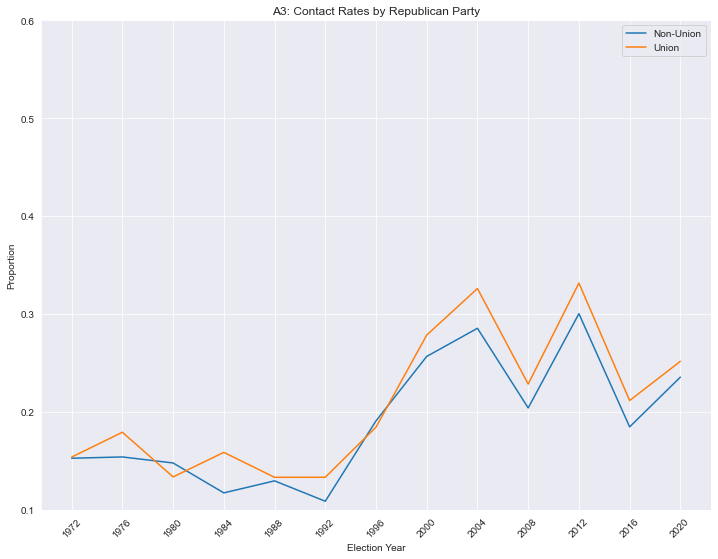

In [181]:
ax = repdat.plot(legend=False,xlabel='Election Year',
           ylabel='Proportion',
           figsize=[12,9],
           grid=True,
           rot=45,
           xticks=years,
           ylim=(0.1,.6))
plt.title("A3: Contact Rates by Republican Party")
ax.legend(labels=("Non-Union",'Union'));

### Union Contact Premium (All Contact Types)

In [182]:
diffs = pd.DataFrame()
diffs['gendiff'] = (gendat['union_gen'] - gendat['non_gen'])
diffs['demdiff'] = (demdat['union_dnc'] - demdat['non_dnc'])
diffs['repdiff'] = (repdat['union_gop'] - repdat['non_gop'])

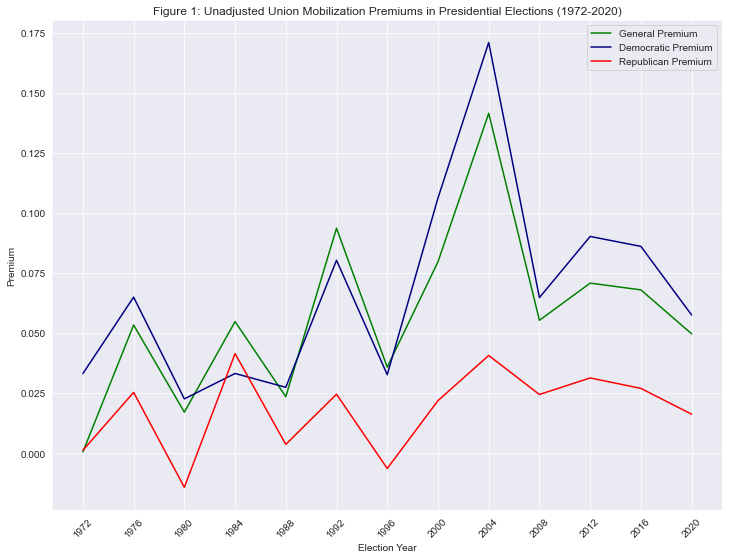

In [183]:
ax = diffs.plot(legend=False,xlabel='Election Year',
           ylabel='Premium',
           figsize=[12,9],
           grid=True,
           rot=45,
           xticks=years,
           style={'gendiff':'green','demdiff':'navy','repdiff':'red'})
plt.title("Figure 1: Unadjusted Union Mobilization Premiums in Presidential Elections (1972-2020)")
ax.legend(labels=("General Premium","Democratic Premium","Republican Premium"));

# Analysis

In [184]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [185]:
df = df[['year','state','contact_gen','contact_dnc','contact_gop','union','educ','female',
          'church','democrat','income','age','black','hispanic','part_strength']]
df

,year,state,contact_gen,contact_dnc,contact_gop,union,educ,female,church,democrat,income,age,black,hispanic,part_strength
0,1972.0,54.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,75.0,0,0,3.0
1,1972.0,54.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,3.0,49.0,0,0,0.0
2,1972.0,45.0,NaN,NaN,NaN,1.0,2.0,0.0,1.0,0.0,3.0,24.0,0,0,1.0
3,1972.0,19.0,1.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,3.0,21.0,0,0,2.0
4,1972.0,17.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,NaN,63.0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38863,2020.0,12.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,26.0,0,0,3.0
38864,2020.0,16.0,0.0,0.0,0.0,0.0,6.0,1.0,1.0,0.0,4.0,52.0,0,0,2.0
38865,2020.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,3.0,45.0,0,1,3.0
38866,2020.0,51.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,3.0,65.0,0,0,3.0


# Union Membership + Party Contact (General)
### Model:

<h1><center> $y_{mobilized} = (\beta_0 + \xi_1{state}) + \beta_2{union} + \beta_3{educ} + \beta_4{partisanstrength} + \beta_5{democrat} + \beta_6{churchgoing} + \beta_7{income} + \beta_8{age} + \beta_9{female} + \beta_{10}{black} + \beta_{11}{hispanic}$ 

In [186]:
random = {'state': '1 + C(state)'} # Creating dictionary for random intercept
formula= 'contact_gen ~ union + educ + part_strength + democrat + church +'
formula+= 'income + age + female +  black + hispanic'

In [187]:
num_years = 13
years_list = [1972 + j*4 for j in range(num_years)] 
 
df_list = [df.loc[df['year'] == iyear].dropna() # Subsetting
          for iyear in years_list]
 
res_list = [f'res_{i}' for i in years_list]
 

In [188]:
mod_List = [sm.BinomialBayesMixedGLM.from_formula( # Run model for each subset year
               formula, random, df_list[i]).fit_vb()
               for i in range(num_years)]
 
results_Dict = {} 
for i,v in enumerate(res_list):
    results_Dict[v] = mod_List[i].summary()

In [189]:
print(mod_List[0].summary())

                 Binomial Mixed GLM Results
              Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------
Intercept        M    -2.5315   0.0723                      
union            M     0.0285   0.1388                      
educ             M     0.1335   0.0183                      
part_strength    M     0.1823   0.0351                      
democrat         M     0.2461   0.0998                      
church           M    -0.1867   0.0806                      
income           M     0.2135   0.0222                      
age              M     0.0060   0.0015                      
female           M     0.0845   0.0961                      
black            M    -0.2662   0.2613                      
hispanic         M    -1.1880   0.9029                      
state            V    -0.6541   0.1149 0.520   0.413   0.654
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as l

In [190]:
# mod_List

### Note: 
Above, I run my models for "General Contact".   

The below models follow the same strategy.  Using for loops, I subset the data, run one Bayesian Binomial GLM w/ randomly varying intercept per presidential election year.

*** 
# Democratic Party Contact

In [191]:
random = {'state': '1 + C(state)'} # Creating dictionary for random effects
formula= 'contact_dnc ~ union + educ + part_strength + democrat + church + income + age + female +  black + hispanic'

In [192]:
dres_list = [f'dres_{i}' for i in years_list]
 
dmod_List = [sm.BinomialBayesMixedGLM.from_formula(
               formula, random, df_list[i]).fit_vb()
               for i in range(num_years)]
 
dresults_Dict = {} 
for i,v in enumerate(dres_list):
    dresults_Dict[v] = dmod_List[i].summary()

## Republican Party Contact

In [193]:
random = {'state': '1 + C(state)'} # Creating dictionary for random effects
formula= 'contact_gop ~ union + educ + part_strength + democrat + church + income + age + female +  black + hispanic'

In [194]:
rres_list = [f'rres_{i}' for i in years_list]
 
rmod_List = [sm.BinomialBayesMixedGLM.from_formula(
               formula, random, df_list[i]).fit_vb()
               for i in range(num_years)]
 
rresults_Dict = {} 
for i,v in enumerate(rres_list):
    dresults_Dict[v] = rmod_List[i].summary()

In [195]:
print(rmod_List[12].summary())

                 Binomial Mixed GLM Results
              Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
------------------------------------------------------------
Intercept        M    -1.9845   0.0291                      
union            M     0.1582   0.0776                      
educ             M     0.1060   0.0054                      
part_strength    M    -0.0233   0.0129                      
democrat         M    -0.3693   0.0451                      
church           M     0.2345   0.0409                      
income           M     0.0595   0.0093                      
age              M     0.0051   0.0005                      
female           M    -0.1000   0.0403                      
black            M    -0.2298   0.1097                      
hispanic         M    -0.0279   0.1028                      
state            V    -0.8830   0.0994 0.414   0.339   0.504
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as l

# Final Stage: Extracting & Plotting Coefficients
Checking location of parameters of interest below:

In [196]:
# mod_List[1].summary()

In [197]:
# mod_List[1].fe_sd[1]

In [198]:
# mod_List[1].params[1]

### General Contact Coefficient Extraction
Below, I extract the 'union' posterior means and SD's.  The same strategy is used for the other 2 DV's

In [199]:
gen_list = []
for i in mod_List:
    gen_list.append(i.params[1]) # Extracting union coefficient for each "Gen Contact Model"
gen_coefs = pd.DataFrame(gen_list) # Adding 'union' coefficients to dataframe

gen_coefs.rename(columns={0:'gen_union'},inplace=True)

In [200]:
gen_sd = []
for i in mod_List:
    gen_sd.append(i.fe_sd[1]) # Adding posterior SD to dataframe
gen_coefs[1] = pd.DataFrame(gen_sd)

gen_coefs.rename(columns={1:'gen_sd'},inplace=True)

In [201]:
gen_coefs['ghdi_lowbound'] = (gen_coefs.gen_union - (gen_coefs.gen_sd * 1.96)) # Create lower bound 2 st. devs
gen_coefs['ghdi_upbound'] = (gen_coefs.gen_union + (gen_coefs.gen_sd * 1.96)) # Create upper bound 2 st. devs

In [202]:
# gen_coefs

### Dem Contact Coefficient Extraction

In [203]:
dem_list = []
for i in dmod_List:
    dem_list.append(i.params[1])
dem_coefs = pd.DataFrame(dem_list) # Adding 'union' coefficients to dataframe

dem_coefs.rename(columns={0:'dem_union'},inplace=True)

In [204]:
dem_sd = []
for i in dmod_List:
    dem_sd.append(i.fe_sd[1]) # Adding posterior SD to dataframe
dem_coefs[1] = pd.DataFrame(dem_sd)

dem_coefs.rename(columns={1:'dem_sd'},inplace=True)

In [205]:
dem_coefs['dhdi_lowbound'] = (dem_coefs.dem_union - (dem_coefs.dem_sd * 1.96)) # Create lower bound 2 st. devs
dem_coefs['dhdi_upbound'] = (dem_coefs.dem_union + (dem_coefs.dem_sd * 1.96)) # Create upper bound 2 st. devs

In [206]:
# dem_coefs

### Rep Contact Coefficient Extraction

In [207]:
rep_list = []
for i in rmod_List:
    rep_list.append(i.params[1])
rep_coefs = pd.DataFrame(rep_list) # Adding 'union' coefficients to dataframe

rep_coefs.rename(columns={0:'rep_union'},inplace=True)

In [208]:
rep_sd = []
for i in rmod_List:
    rep_sd.append(i.fe_sd[1]) # Adding posterior SD to dataframe
rep_coefs[1] = pd.DataFrame(rep_sd)

rep_coefs.rename(columns={1:'rep_sd'},inplace=True)

In [209]:
rep_coefs['rhdi_lowbound'] = (rep_coefs.rep_union - (rep_coefs.rep_sd * 1.96)) # Create lower bound 2 st. devs
rep_coefs['rhdi_upbound'] = (rep_coefs.rep_union + (rep_coefs.rep_sd * 1.96)) # Create upper bound 2 st. devs

In [210]:
# rep_coefs

### Combining Data

In [211]:
final = gen_coefs
final = final.join(dem_coefs,how='left')
final = final.join(rep_coefs,how='left')
final.drop(columns=['gen_sd','dem_sd','rep_sd'])
final.index=years

In [212]:
final

,gen_union,gen_sd,ghdi_lowbound,ghdi_upbound,dem_union,dem_sd,dhdi_lowbound,dhdi_upbound,rep_union,rep_sd,rhdi_lowbound,rhdi_upbound
1972,0.028479,0.138759,-0.243489,0.300446,0.131552,0.150630,-0.163683,0.426787,-0.004865,0.171621,-0.341242,0.331513
1976,0.285365,0.113586,0.062736,0.507993,0.388786,0.121806,0.150047,0.627525,0.366467,0.136492,0.098942,0.633991
1980,0.143142,0.138143,-0.127618,0.413902,0.289829,0.162143,-0.027971,0.607628,0.032217,0.170627,-0.302212,0.366647
1984,0.393352,0.122993,0.152286,0.634417,0.225871,0.140422,-0.049356,0.501097,0.454682,0.147112,0.166342,0.743021
1988,0.126672,0.137958,-0.143726,0.397070,0.163874,0.157646,-0.145112,0.472861,0.080384,0.170032,-0.252878,0.413647
1992,0.315285,0.127856,0.064686,0.565883,0.359014,0.139666,0.085269,0.632758,0.212251,0.163934,-0.109060,0.533562
1996,0.049939,0.145881,-0.235987,0.335865,0.051698,0.170217,-0.281928,0.385324,-0.100912,0.173431,-0.440838,0.239013
2000,0.295648,0.158708,-0.015419,0.606715,0.524609,0.166583,0.198106,0.851112,0.093719,0.173176,-0.245706,0.433145
2004,0.320260,0.176652,-0.025977,0.666497,0.476437,0.175084,0.133273,0.819600,-0.149546,0.188330,-0.518673,0.219581
2008,0.055306,0.146088,-0.231027,0.341639,0.151570,0.148810,-0.140098,0.443238,0.106038,0.170605,-0.228349,0.440425


Above is the final data I will use to plot the union coefficients over time with 95% HDI intervals.

## Plotting 'Union' Coefficients Over Time

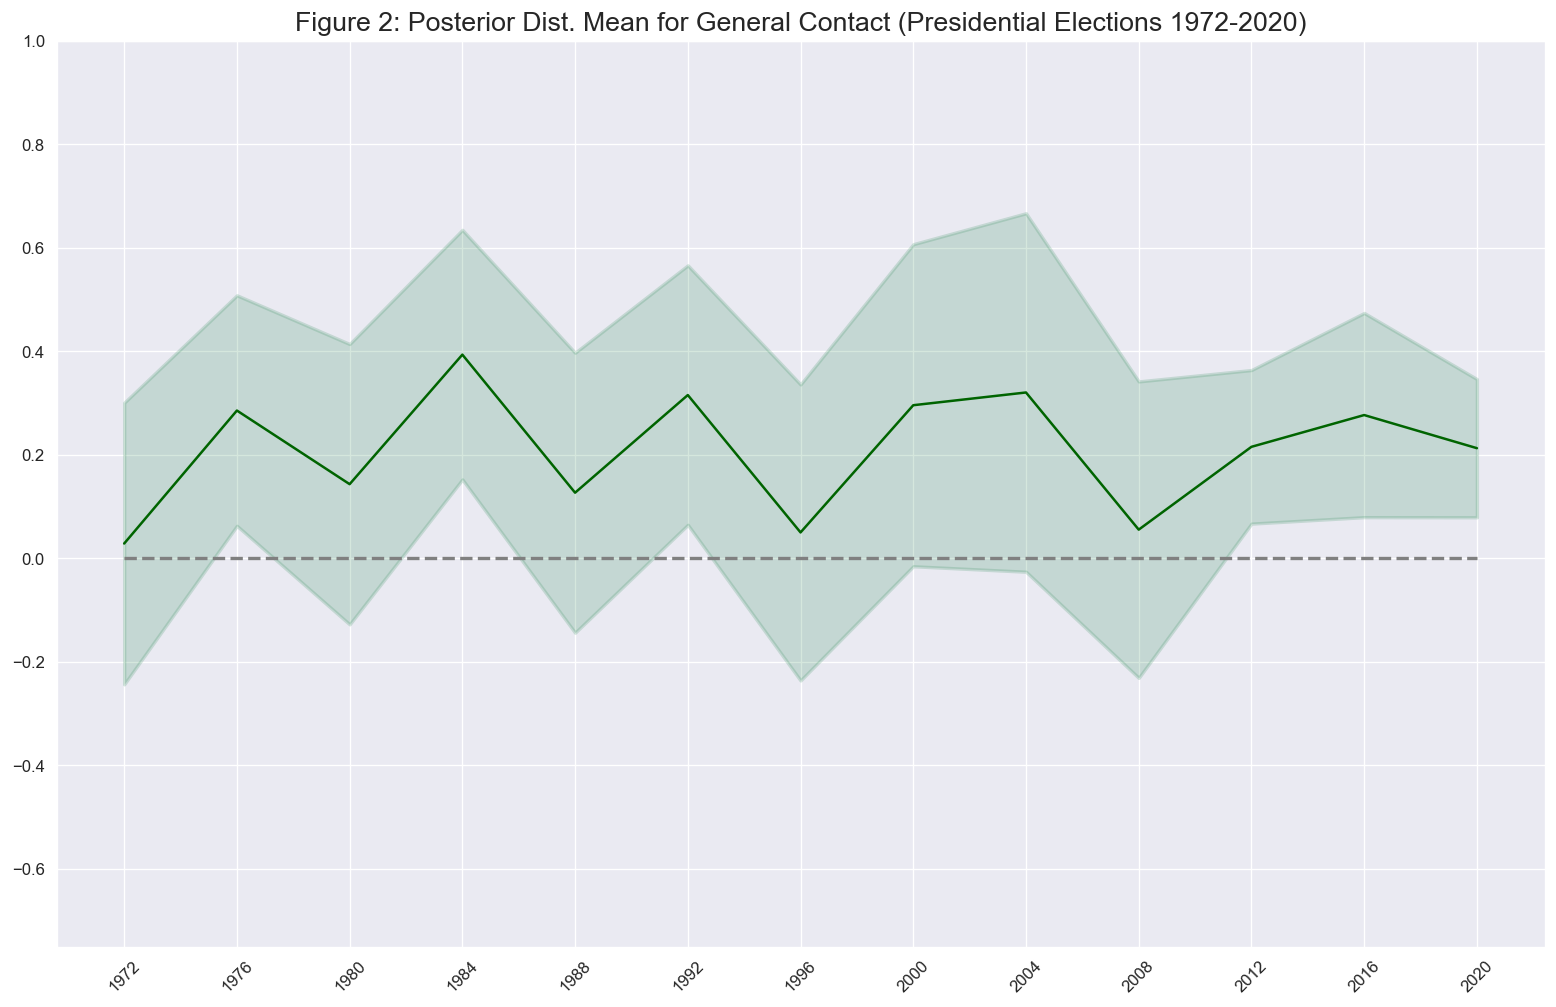

In [213]:
# Plotting for General Contact
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-.75,1)
plt.fill_between(x, y1=final['ghdi_upbound'], 
                 y2=final['ghdi_lowbound'], alpha=0.2, linewidth=2, color='seagreen')
plt.plot(x,final['gen_union'],color='darkgreen')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Figure 2: Posterior Dist. Mean for General Contact (Presidential Elections 1972-2020)', fontsize=16)
plt.show()

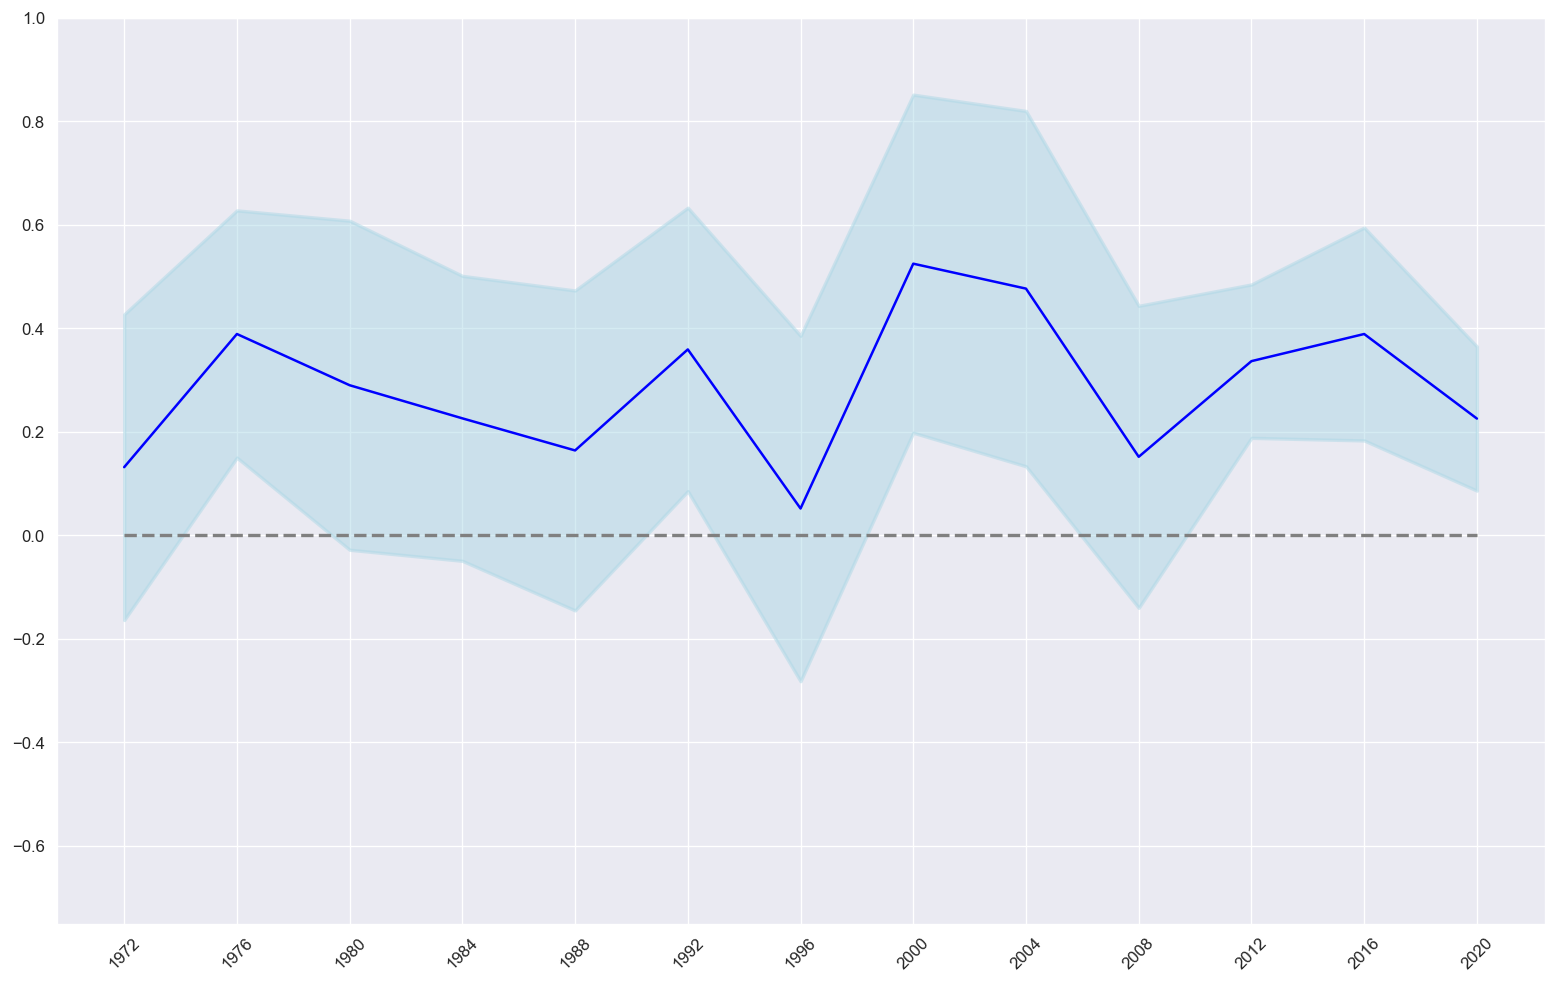

In [214]:
# Plotting Democratic Contact
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-.75,1)
plt.fill_between(x, y1=final['dhdi_upbound'], 
                 y2=final['dhdi_lowbound'], alpha=0.5, linewidth=2, color='lightblue')
plt.plot(x,final['dem_union'],color='blue')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.show()

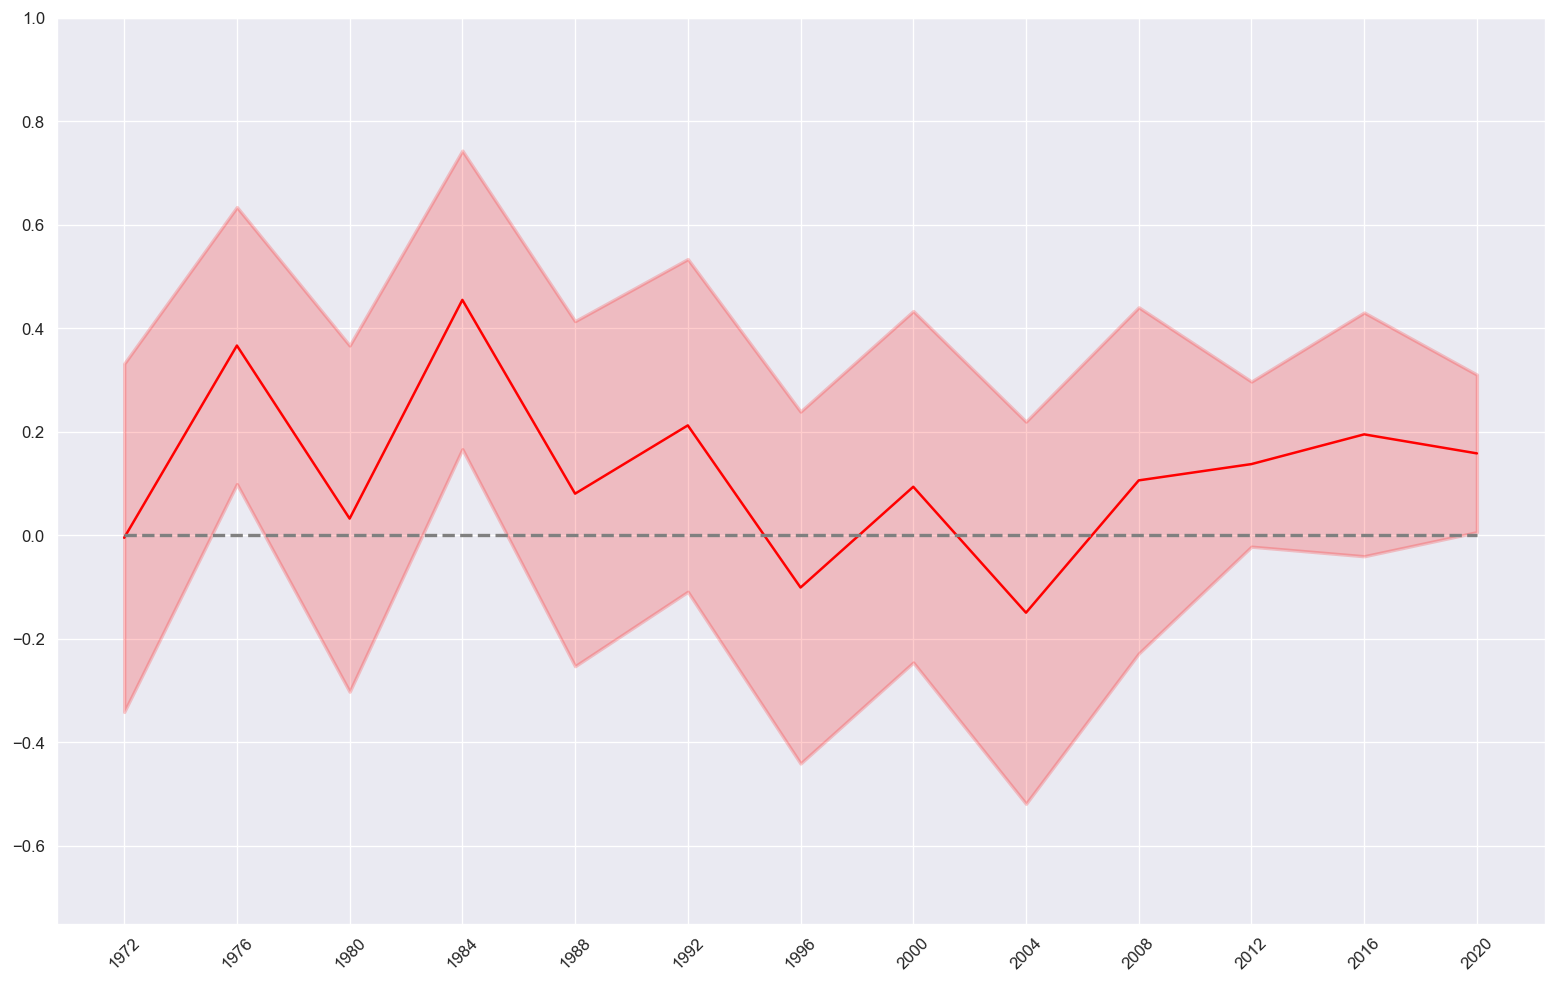

In [215]:
# Plotting Republican Contact
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-.75,1)
plt.fill_between(x, y1=final['rhdi_upbound'], 
                 y2=final['rhdi_lowbound'], alpha=0.2, linewidth=2, color='red')
plt.plot(x,final['rep_union'],color='red')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.show()

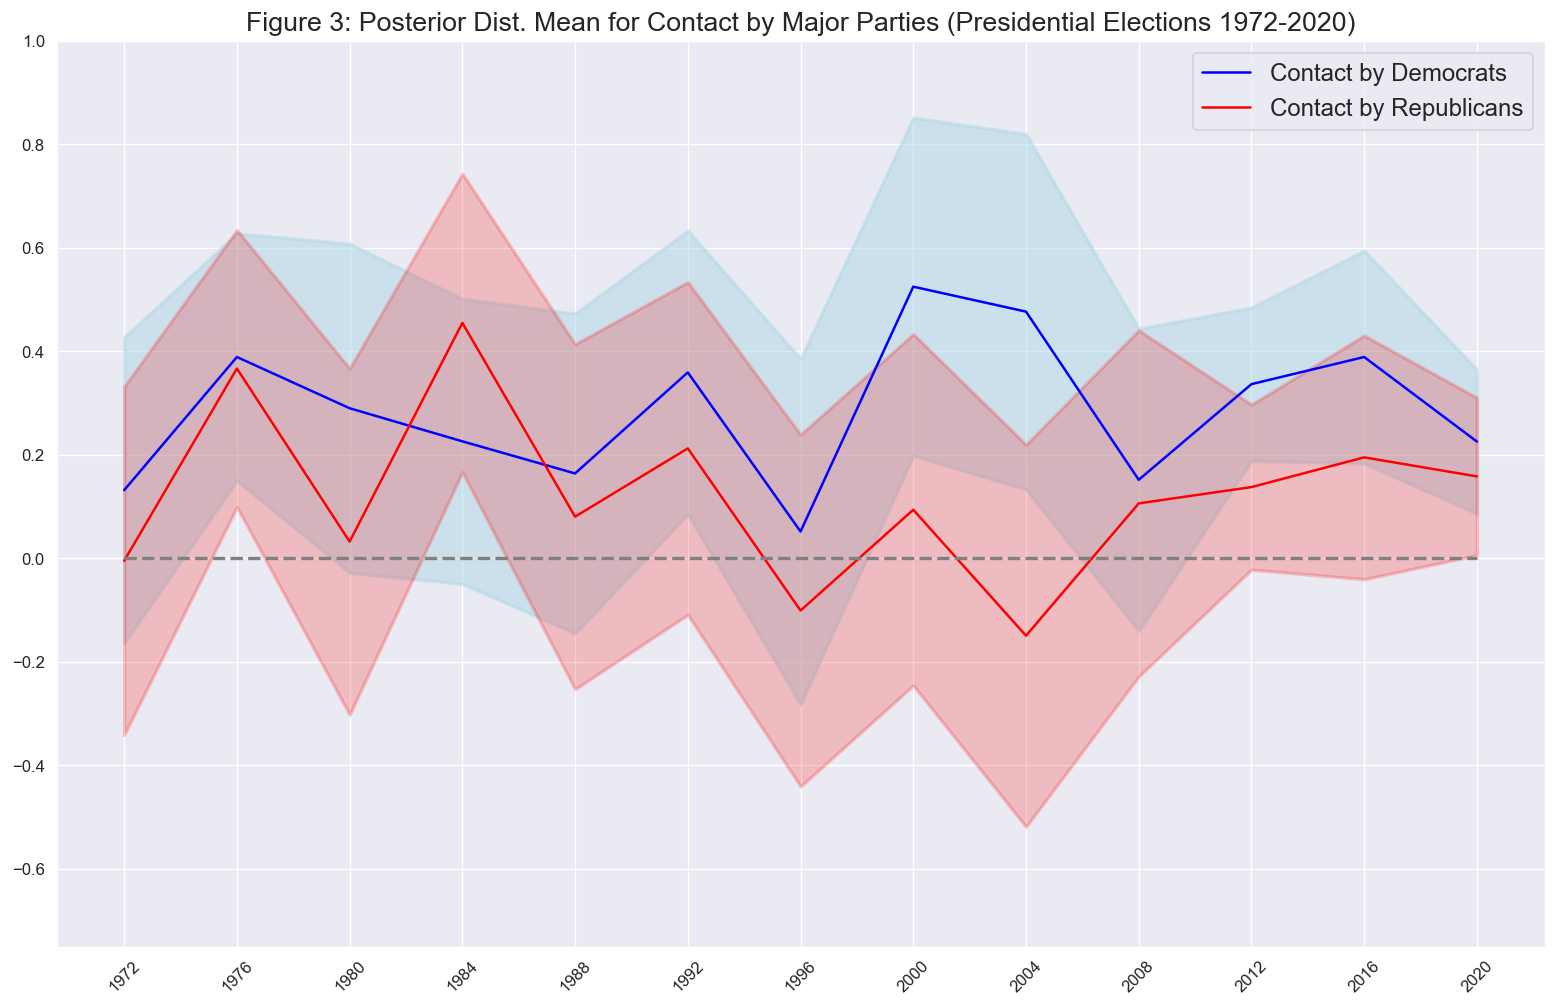

In [216]:
# Plotting DNC/GOP contact together
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-.75,1)

plt.fill_between(x, y1=final['dhdi_upbound'], 
                 y2=final['dhdi_lowbound'], alpha=0.5, linewidth=2, color='lightblue')

plt.fill_between(x, y1=final['rhdi_upbound'], 
                 y2=final['rhdi_lowbound'], alpha=0.2, linewidth=2, color='red')


plt.plot(x,final['dem_union'],color='blue',label="Contact by Democrats")
plt.plot(x,final['rep_union'],color='red',label="Contact by Republicans")

plt.legend(fontsize='x-large')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Figure 3: Posterior Dist. Mean for Contact by Major Parties (Presidential Elections 1972-2020)', fontsize=16)
plt.show()

In [217]:
# ax = diffs.plot(legend=False,xlabel='Election Year',
#            ylabel='Premium',
#            figsize=[12,9],
#            grid=True,
#            rot=45,
#            xticks=years,
#            style={'gendiff':'green','demdiff':'navy','repdiff':'red'})
# plt.title("Base Union Mobilization Premiums in Presidential Elections (1972-2020)")
# ax.legend(labels=("General Premium","Democratic Premium","Republican Premium"));

### Plotting Difference in Posterior Means

In [218]:
final['diff'] = final['dem_union'] - final['rep_union']

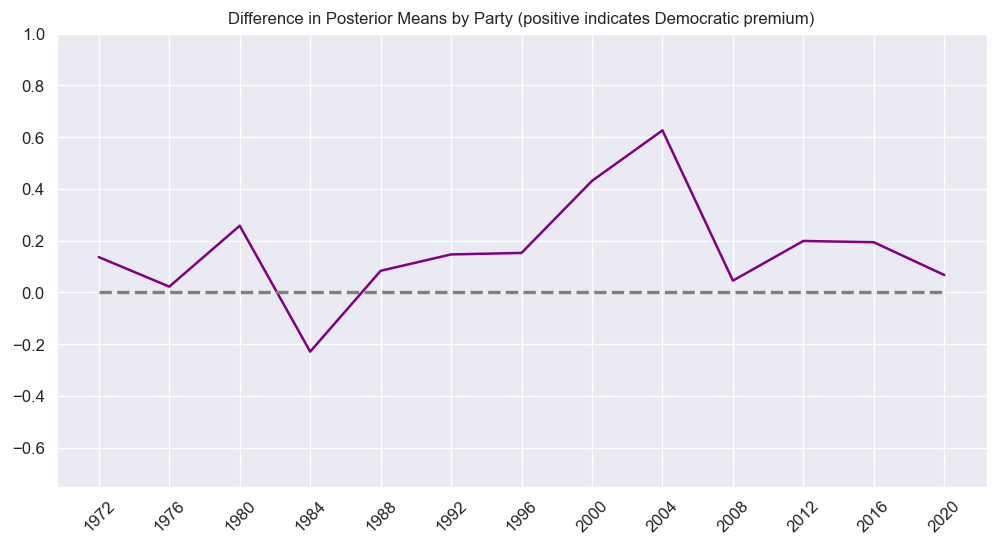

In [219]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi= 120)
ax.set_ylim(-.75,1)
plt.plot(x,final['diff'],color='purple')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Difference in Posterior Means by Party (positive indicates Democratic premium)', fontsize=10)
plt.show()

***
***
# Supplemental Analysis + Plots
***
***

In [220]:
df_nodrop = [data3.loc[data3['year'] == iyear]
          for iyear in years_list]

In [221]:
sizes = []
for i in df_list:
    sizes.append(i.shape[0]) # Adding posterior SD to dataframe
sizes = pd.DataFrame(sizes)

In [222]:
sizes2 = []
for i in df_nodrop:
    sizes2.append(i.shape[0]) # Adding posterior SD to dataframe
sizes[1] = pd.DataFrame(sizes2)

In [223]:
sizes.rename(columns={0:'dropped',1:'original'},inplace=True)
sizes.index=years

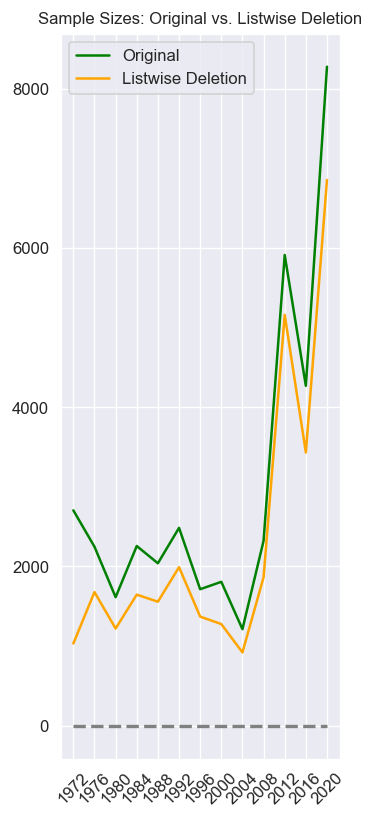

In [224]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(3,8), dpi= 120)
plt.plot(x,sizes['original'],color='green',label='Original')
plt.plot(x,sizes['dropped'],color='orange',label='Listwise Deletion')
plt.xticks(years,rotation=45)
plt.legend()
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Sample Sizes: Original vs. Listwise Deletion', fontsize=10)
plt.show()

In [225]:
sizes.dropped.sum()

30004

In [226]:
sizes['diff'] = sizes.original - sizes.dropped
sizes['propdropped'] = (sizes['diff'] / sizes['original'])

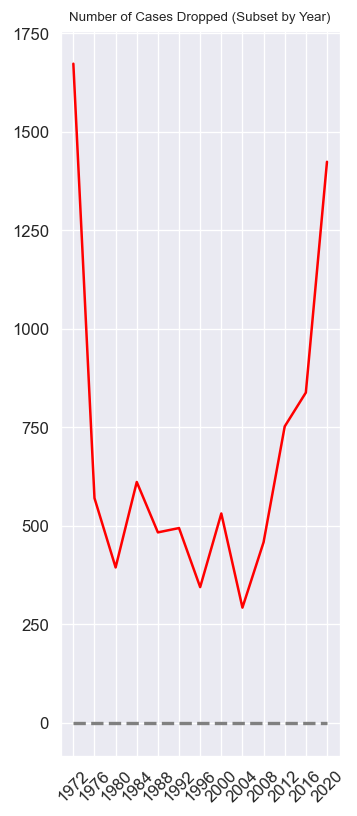

In [227]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(3,8), dpi= 120)
plt.plot(x,sizes['diff'],color='red')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Number of Cases Dropped (Subset by Year)', fontsize=8)
plt.show()

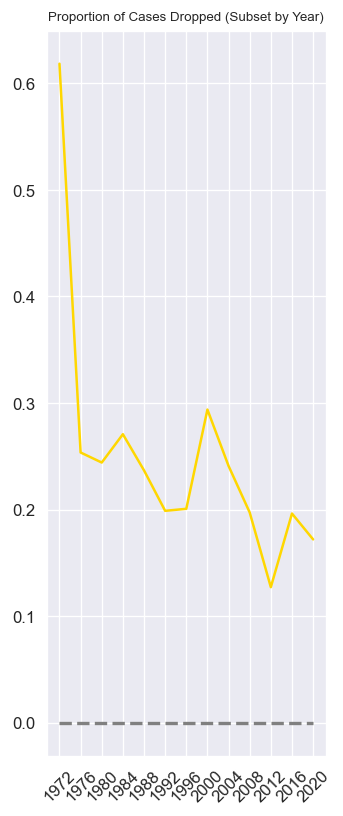

In [228]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(3,8), dpi= 120)
plt.plot(x,sizes['propdropped'],color='gold')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('Proportion of Cases Dropped (Subset by Year)', fontsize=8)
plt.show()

## State-Level Random Intercepts
vc_mean
vc_sd
### General

In [229]:
state_list = []
for i in mod_List:
    state_list.append(i.vc_mean[0])
state_coefs = pd.DataFrame(state_list)

state_coefs.rename(columns={0:'vc_mean'},inplace=True)

In [230]:
state_sd = []
for i in mod_List:
    state_sd.append(i.vc_sd[0])
state_coefs[1] = pd.DataFrame(state_sd)

state_coefs.rename(columns={1:'vc_sd'},inplace=True)

In [231]:
state_coefs['vc_lowbound'] = (state_coefs.vc_mean - state_coefs.vc_sd)
state_coefs['vc_upbound'] = (state_coefs.vc_mean + state_coefs.vc_sd)

In [232]:
# state_coefs

### DNC

In [233]:
dstate_list = []
for i in dmod_List:
    dstate_list.append(i.vc_mean[0])
dstate_coefs = pd.DataFrame(dstate_list)

dstate_coefs.rename(columns={0:'vc_mean'},inplace=True)

In [234]:
dstate_sd = []
for i in dmod_List:
    dstate_sd.append(i.vc_sd[0])
dstate_coefs[1] = pd.DataFrame(dstate_sd)

dstate_coefs.rename(columns={1:'vc_sd'},inplace=True)

In [235]:
dstate_coefs['vc_lowbound'] = (dstate_coefs.vc_mean - dstate_coefs.vc_sd)
dstate_coefs['vc_upbound'] = (dstate_coefs.vc_mean + dstate_coefs.vc_sd) 

### RNC

In [236]:
rstate_list = []
for i in rmod_List:
    rstate_list.append(i.vc_mean[0])
rstate_coefs = pd.DataFrame(dstate_list)

rstate_coefs.rename(columns={0:'vc_mean'},inplace=True)

In [237]:
rstate_sd = []
for i in rmod_List:
    rstate_sd.append(i.vc_sd[0])
rstate_coefs[1] = pd.DataFrame(rstate_sd)

rstate_coefs.rename(columns={1:'vc_sd'},inplace=True)

In [238]:
rstate_coefs['vc_lowbound'] = (rstate_coefs.vc_mean - rstate_coefs.vc_sd)
rstate_coefs['vc_upbound'] = (rstate_coefs.vc_mean + rstate_coefs.vc_sd)

### Plots

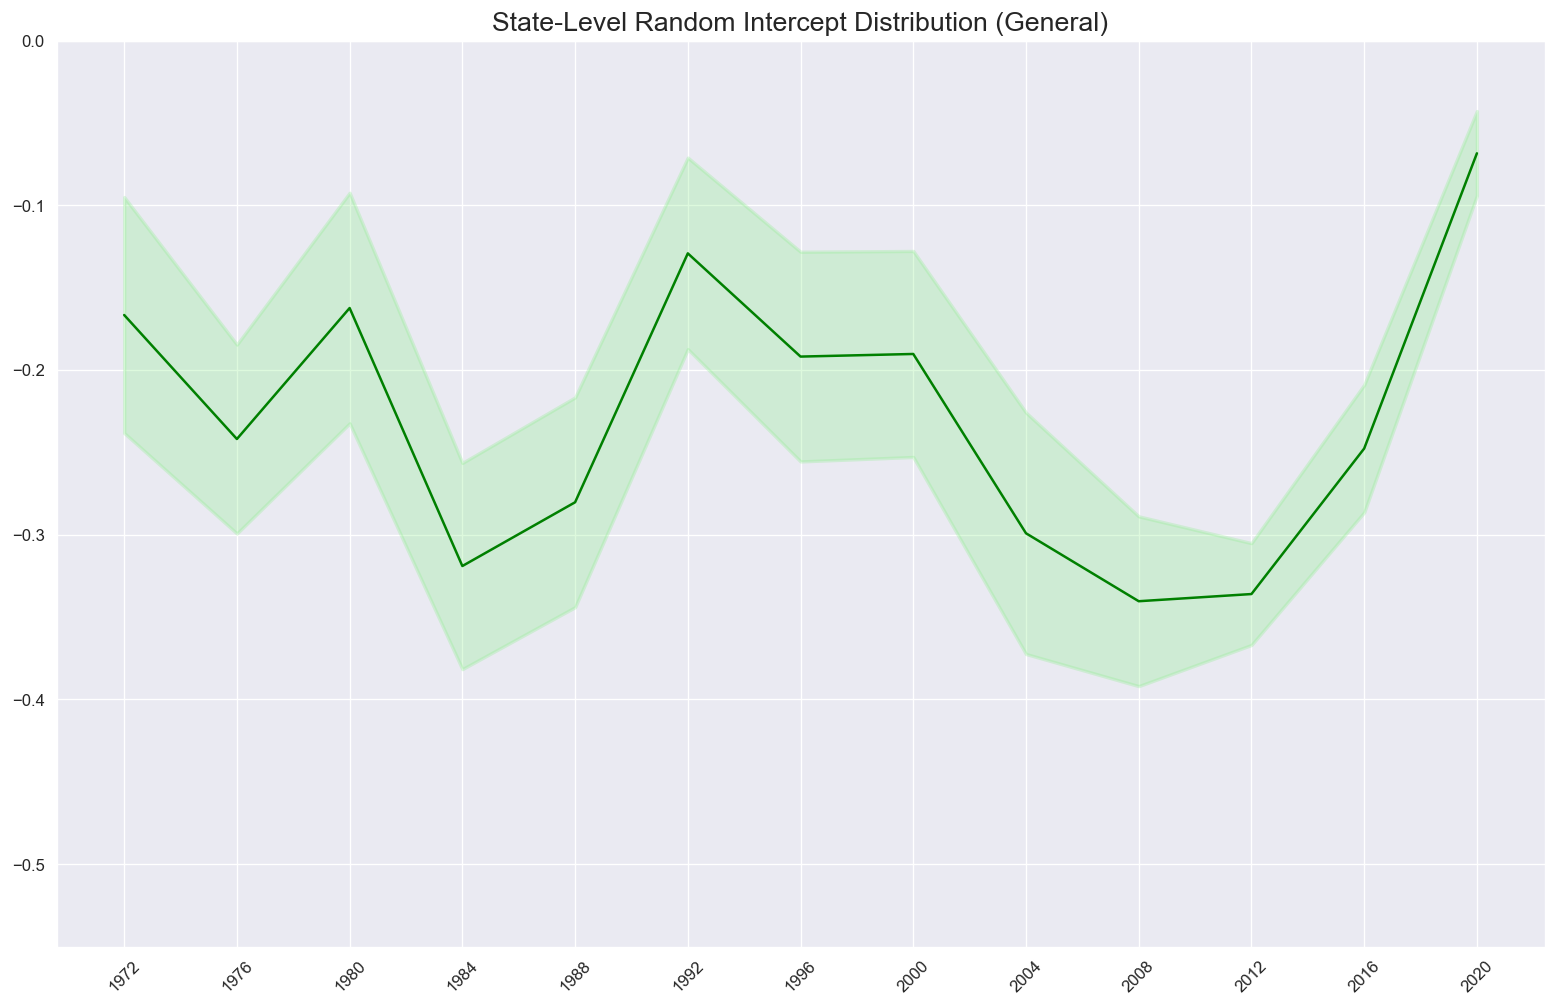

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-0.55,0)
plt.fill_between(x, y1=state_coefs['vc_upbound'], 
                 y2=state_coefs['vc_lowbound'], alpha=0.3, linewidth=2, color='lightgreen')
plt.plot(x,state_coefs['vc_mean'],color='green')
plt.xticks(years,rotation=45)
plt.title('State-Level Random Intercept Distribution (General)', fontsize=16)
plt.show()

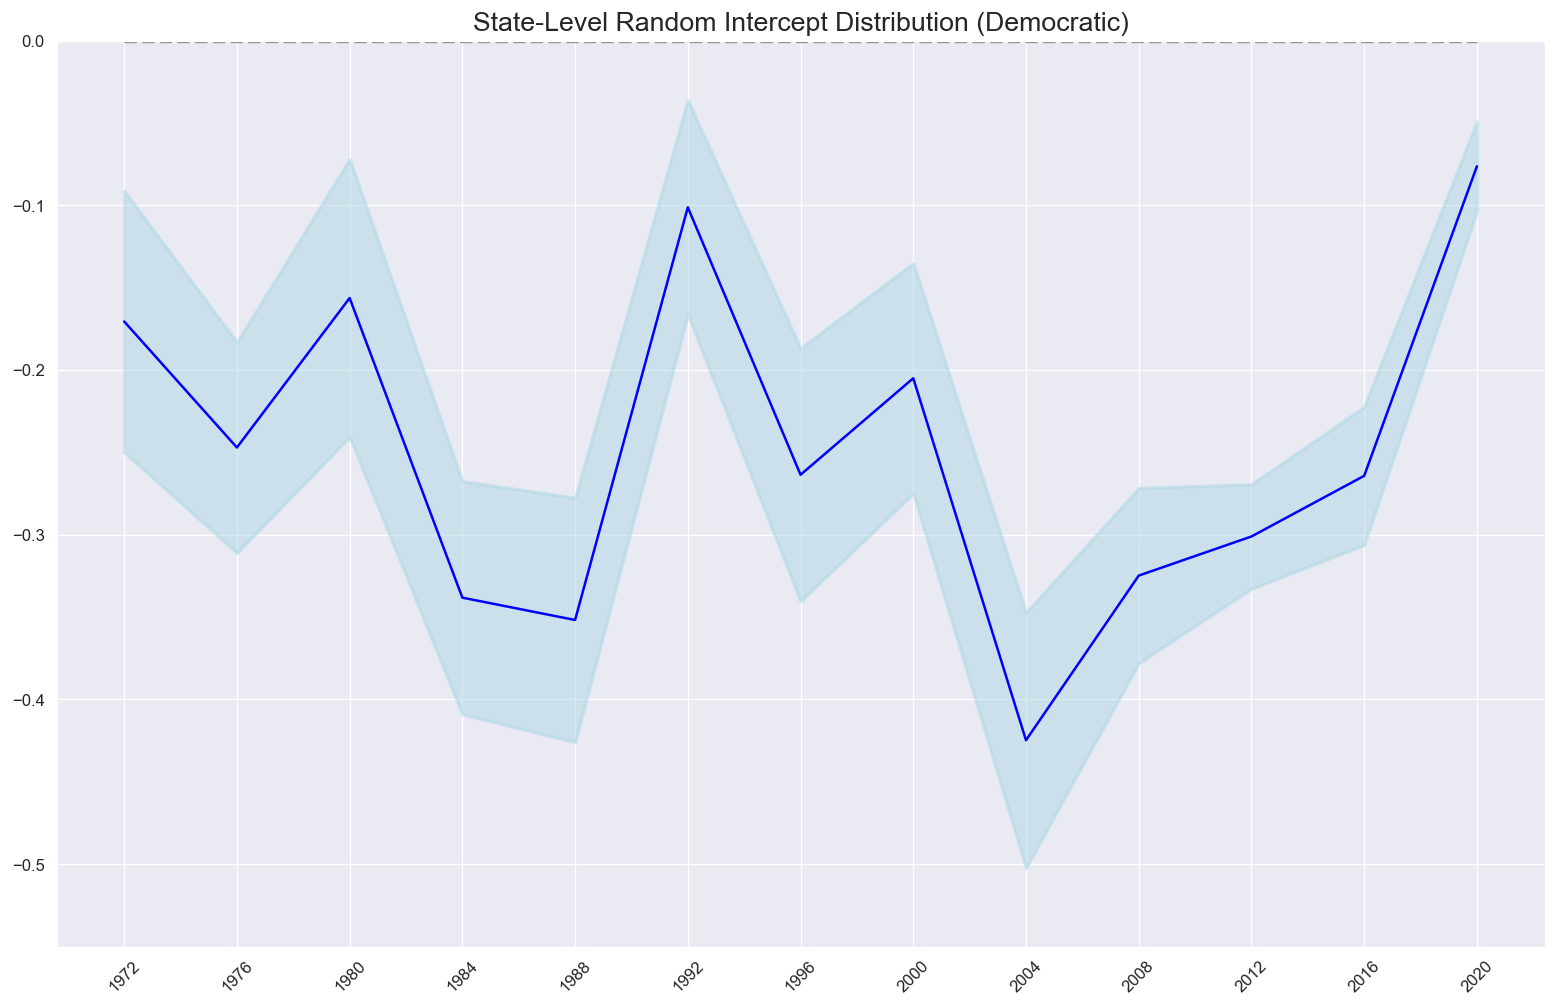

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-0.55,0)
plt.fill_between(x, y1=dstate_coefs['vc_upbound'], 
                 y2=dstate_coefs['vc_lowbound'], alpha=0.5, linewidth=2, color='lightblue')
plt.plot(x,dstate_coefs['vc_mean'],color='blue')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('State-Level Random Intercept Distribution (Democratic)', fontsize=16)
plt.show()

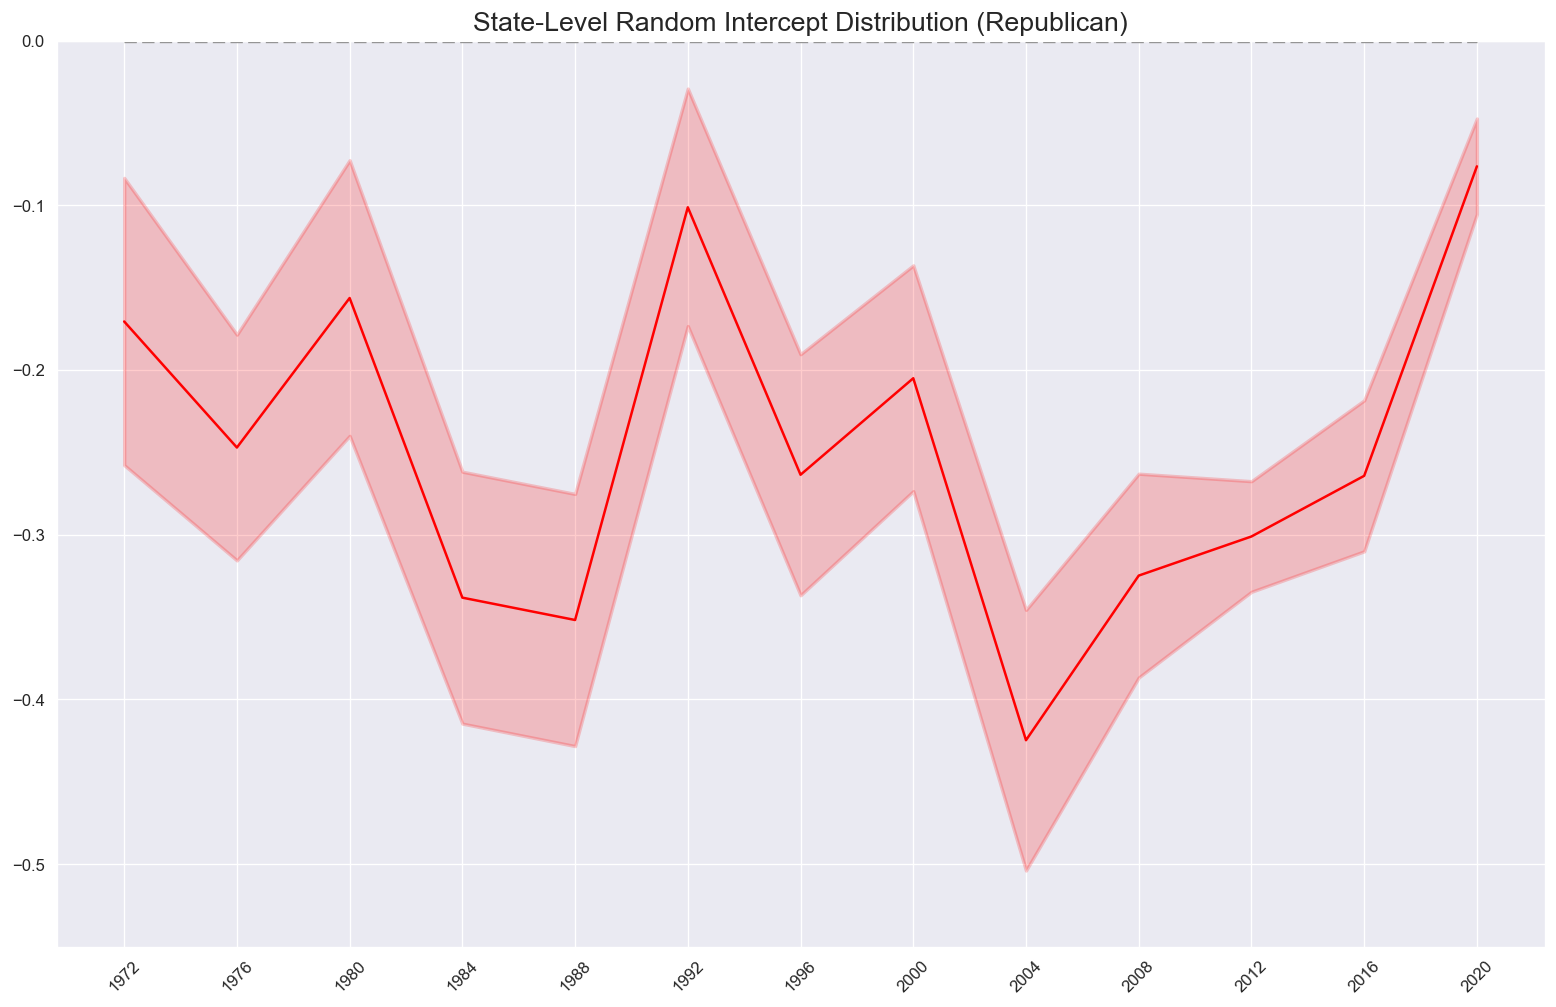

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi= 120)
ax.set_ylim(-0.55,0)
plt.fill_between(x, y1=rstate_coefs['vc_upbound'], 
                 y2=rstate_coefs['vc_lowbound'], alpha=0.2, linewidth=2, color='red')
plt.plot(x,rstate_coefs['vc_mean'],color='red')
plt.xticks(years,rotation=45)
plt.hlines(y=0, xmin=np.min(years), xmax=np.max(years), linewidth=2, color='gray',linestyle='--')
plt.title('State-Level Random Intercept Distribution (Republican)', fontsize=16)
plt.show()